In [325]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as t
from torchvision import datasets
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import csv
from sklearn.model_selection import train_test_split




In [326]:
# helper Class

class ImageFolder2CSV:
    def __init__(self, ImagePath, CsvName, transform):
        """
            Args --> ImagePath: the path to the folder of the image
                 --> CsvName: the name for which you want to save the CSV file
                 --> transform: the transformations you want to apply on the data
        """

        self.ImagePath = ImagePath
        self.CsvName = CsvName
        self.transform = transform
    
    def change(self):
        """
            Converts and ImageFolder to a dataset
            Uses Pytorch ImageFolder --> refer to Pytorch Documentation

        """

        dataset = datasets.ImageFolder(self.ImagePath, transform=self.transform)
        return dataset


    def Image2Csv(self):
        """
        Takes in an Image dataset or an image of pixels and produces a csv file of pixels out of the image

        Args --> [dataset:  a dataset of pixels
                            Assumes the image is a gray scale image
                            example --> [1, 80, 80]
                Path: the path to which the Csv file is to be saved. type: string
        
        
        ]
        
        
        """

        with open(self.CsvName, 'w') as out:
            dataset = self.change()
            csv_out = csv.writer(out)
            # write to the pixel value rows
            #csv_out.writerow(columns)

            # iterate through the data to produce the splitted pixels
            for i in range(len(dataset)):
                splittedAndLabel = [dataset[i][1]]
                singleSub = dataset[i][0].flatten()
                for j in singleSub:
                    splittedAndLabel.append(j.item())
                    
                csv_out.writerow(splittedAndLabel)

In [327]:
transform = t.Compose(
    [
        #t.ToPILImage(),
        
        t.Resize((50, 50)),
        t.ToTensor(),
        t.Grayscale(num_output_channels=1)
    ]
)

In [328]:
call = ImageFolder2CSV('./Data/operation_redDawnAmmo/test_set/test_set', 'test_set.csv', transform)

In [329]:
dataF = call.change()

In [330]:
#only to be used when needed
#call.Image2Csv()

In [331]:
npData = np.loadtxt(open('train_data.csv', 'rb'), delimiter=',')
npDataF = np.loadtxt(open('test_set.csv', 'rb'), delimiter=',')

In [332]:
# Doing Extra work to seperate the data
# Hypothesis:  working with data drawm from different folders is producing abnormal results
labels = npData[:, 0]
subData = npData[:, 1:]
subData = subData.reshape(subData.shape[0], 1, 50, 50)

labelsF = npDataF[:, 0]
subDataF = npDataF[:, 1:]
subDataF  = subDataF.reshape(subDataF.shape[0], 1, 50, 50)

In [333]:
labels = torch.tensor(labels).long()
data = torch.tensor(subData).float()

labelsF = torch.tensor(labelsF).long()
dataF = torch.tensor(subDataF).float() 

In [334]:
# all tryout code to see why the models performs terribly on unseen data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)
train_dataF, test_dataF, train_labelsF, test_labelsF = train_test_split(dataF, labelsF, test_size=0.1)



train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_dataF = TensorDataset(train_dataF, train_labelsF)
test_dataF = TensorDataset(test_dataF, test_labelsF)



# creating two data distributions, one for main testing and the other for both training and testing
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data[0][0].size(0))

train_loaderF = DataLoader(train_dataF, batch_size=32, shuffle=True)
test_loaderF = DataLoader(test_dataF, batch_size=test_dataF[0][0].size(0))



1820

In [204]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [205]:
print(len(data))
print(data[8000][0].shape)

8005
torch.Size([50, 50])


In [206]:
type(data)

torch.Tensor

In [207]:
classes = dataF.classes
classes

['cats', 'dogs']

['cats', 'dogs']

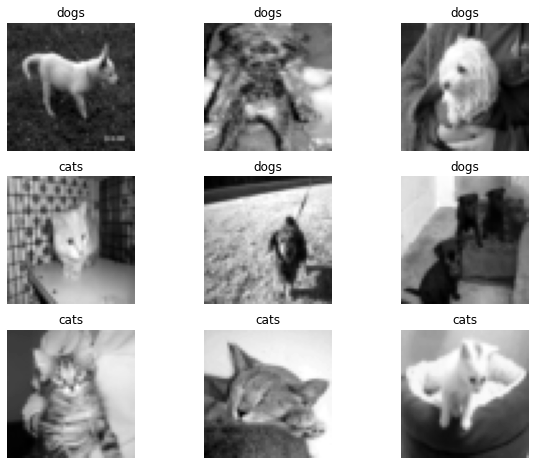

In [309]:
# Visualize the data
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataF), size=(1,)).item()
    img, label = dataF[sample_idx][0], dataF[sample_idx][1]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(classes[label])
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()




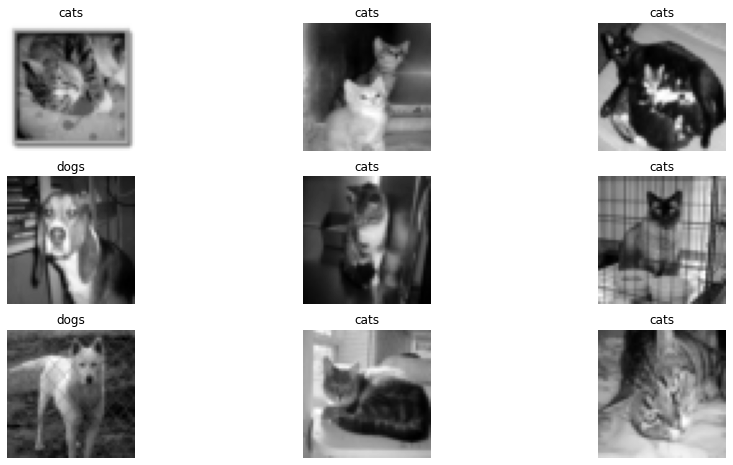

In [209]:
from random import randint
#create a figure
figure = plt.figure(figsize=(15, 8))
col, rol =3, 3

for i in range(1, rol * col + 1):
    x = randint(1, len(data))
    img = data[x]
    figure.add_subplot(col, rol, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[labels[x]])
    plt.axis("off")
plt.show() 


In [210]:
# create two models
# lossfun --> BCE with soft max
# optimizer --> Adam

def createModel():

    class model(nn.Module):

        def __init__(self) -> None:
            super().__init__()
            self.fc1 = nn.Linear(50 * 50, 20)
            self.fc2 = nn.Linear(20, 20)
            self.fc3 = nn.Linear(20, 8)
            self.output = nn.Linear(8, 2)
        
        def forward(self, x):
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = torch.log_softmax(self.output(x), axis=1)
            return x

    Classifier = model()

    lossfun = nn.NLLLoss()
    optimizer = torch.optim.Adam(Classifier.parameters(), lr=0.001)

    return Classifier, lossfun, optimizer
        



In [211]:
def createCnnModel():
    class model(nn.Module):
        def __init__(self) -> None:
            super().__init__()
            self.conv1 = nn.Conv2d(1, 16, 5, padding=1)
            #self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(16, 5, 5, padding=1)
            self.fc1 = nn.Linear(5*11*11, 120)
            self.output = nn.Linear(120, 2)

        def forward(self, x):
            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            x = x.view(x.size(0), -1)
            #print(x.shape)
            x = F.leaky_relu(self.fc1(x))
            x = self.output(x)
            return x
    classifier = model()
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

    return classifier, lossfun, optimizer



In [212]:
#create the dataloader using the train dataset
#train_loader = DataLoader(data, batch_size=32, shuffle=True)

In [213]:
# test the model to see if everything is fine
X, y = next(iter(train_loader))
print(X.shape)
classifier, lossfun, optimizer = createModel()

summary(classifier, (50, 50))




torch.Size([32, 1, 50, 50])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]          50,020
            Linear-2                   [-1, 20]             420
            Linear-3                    [-1, 8]             168
            Linear-4                    [-1, 2]              18
Total params: 50,626
Trainable params: 50,626
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [214]:
yhat = classifier(X)
lossfun(yhat, y)

tensor(0.7277, grad_fn=<NllLossBackward0>)

In [215]:
# # the test data
# testdata = datasets.ImageFolder('./Data/operation_redDawnAmmo/test_set/test_set/', transform=transform)
# test_loader = DataLoader(testdata, batch_size=testdata[0][0].size(0))


In [227]:
def trainTheModel(func):
  numepochs = 20
  losses = torch.zeros(numepochs)
  trainAcc = torch.zeros(numepochs)
  testAcc = torch.zeros(numepochs)

  net, lossf, optim = func()
  net.to(device)


  for epoch in range(numepochs):
    batchLosses = []
    batchAcc = []


    net.train()
    for X, y in train_loader:
      # send data to device
      X, y = X.to(device), y.to(device)

      yhat = net(X)

      loss = lossf(yhat, y)
      batchLosses.append(loss.item())

      optim.zero_grad()
      loss.backward()
      optim.step()

      batchAcc.append( torch.mean((torch.argmax(yhat,axis=1) == y).float()).item())
    
    trainAcc[epoch]  = 100*np.mean(batchAcc)
    losses[epoch] = np.mean(batchLosses)
    
    # evaluate the model
    net.eval()
    X, y = next(iter(test_loader))
    X, y = X.to(device), y.to(device)
    with torch.no_grad():
      yhat = net(X)
    
    testAcc[epoch]  = 100*torch.mean((torch.argmax(yhat,axis=1) == y).float()).item()


    
    
    print("epoch {} and accuracy{}".format(epoch, trainAcc))
  
  return trainAcc, testAcc, losses, net


In [397]:
trainAcc, testAcc, losses , model = trainTheModel(createCnnModel)

epoch 0 and accuracytensor([57.4115,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])
epoch 1 and accuracytensor([57.4115, 64.0348,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])
epoch 2 and accuracytensor([57.4115, 64.0348, 66.9248,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])
epoch 3 and accuracytensor([57.4115, 64.0348, 66.9248, 69.0542,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])
epoch 4 and accuracytensor([57.4115, 64.0348, 66.9248, 69.0542, 70.8656,  0.0000,  0.0000,  0.0000,


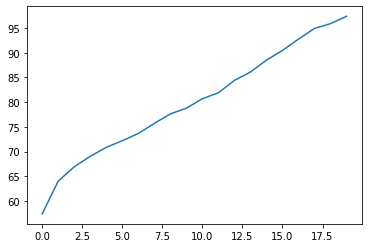

In [447]:
plt.plot(trainAcc)

In [400]:
torch.save(model.state_dict(), 'model2.pth')

In [445]:
model.eval()
X, y = next(iter(test_loaderF))
with torch.no_grad():
    yhat = model(X)
    testAcc  = 100*torch.mean((torch.argmax(yhat,axis=1) == y).float()).item()
testAcc
    

100.0

IndexError: index 32 is out of bounds for dimension 0 with size 32

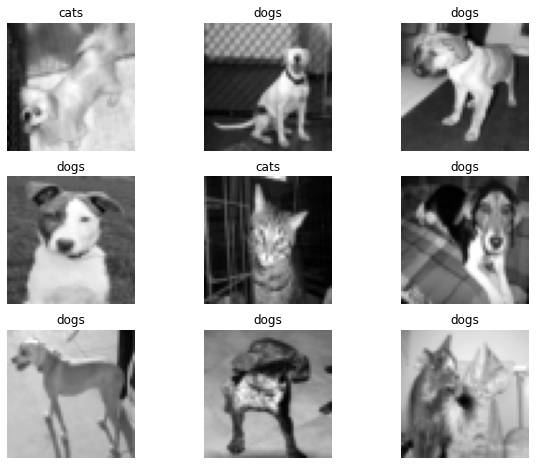

In [450]:
figure = plt.figure(figsize=(10, 8))
col, row = 3, 3
model.eval()
X, y = next(iter(train_loaderF))
with torch.no_grad():
    yhat = model(X)

for i in range(1, col * row + 1):
    x = randint(1, len(train_loader))
    #image, label = train_data[x]
    figure.add_subplot(row, col, i)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(classes[torch.argmax(yhat, axis=1)[i]])
    plt.axis("off")
plt.show()


torch.Size([1, 50, 50])

In [242]:
y

tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1])